# NLP Standard Project:

- Students: **Matteo Belletti**, **Alessandro Pasi**, **Stricescu Razvan Ciprian**.

The Standard Project is about addressing this task: Emotion Discovery and Reasoning its Flip in Conversation (EDiReF), SemEval 2024 Task 10, SUBTASK iii (English only) 

### Libraries and dependencies:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import random
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
import pandas as pd
import json
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, f1_score
from torch import cuda
import torch.optim as to
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

C:\Users\alepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In order to better assess the project we trained and evaluated our models on five different seeds. The results are reported in the report but also in the notebook in the section "Results".

Seed selection:

In [2]:
#RANDOM_SEED = 42
#RANDOM_SEED = 2
#RANDOM_SEED = 4
#RANDOM_SEED = 22
RANDOM_SEED = 420
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
transformers.set_seed(RANDOM_SEED)

## Data loading and preprocessing:

The data contains 4000 short English dialogues from the TV show "Friends". Each dialogue is composed of different sentences, each of which is annotated with a label that indicates the emotion expressed by the speaker and whether it triggers that emotion or not.

The labels for emotion are: 
| Emotion: | neutral | joy | sadness | fear | anger | suprise | disgust |
|----------|---------|-----|---------|------|-------|---------|---------|

The labels for trigger are:
| Trigger: | 0 | 1 |
|----------|---------|-----|


The data is loaded and preprocessed as follows:

In [3]:
# open json in project_data_MELD folder
try:
    with open('project_data_MELD/MELD_train_efr.json') as f: # Modify this path to your local path
        data = json.load(f)
except:
    with open('MELD_train_efr.json') as f:
        data = json.load(f)
print(f"Number of samples: {len(data)}")
print(f"Example of a sample: {data[0]}")

Number of samples: 4000
Example of a sample: {'episode': 'utterance_0', 'speakers': ['Chandler', 'The Interviewer', 'Chandler', 'The Interviewer', 'Chandler'], 'emotions': ['neutral', 'neutral', 'neutral', 'neutral', 'surprise'], 'utterances': ["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.'], 'triggers': [0.0, 0.0, 0.0, 1.0, 0.0]}


In order to easily load the data we used the pandas library. The data is loaded from the list previously created and then it is converted into a pandas dataframe. 

We also drop the episode column, which functions as an index, as it is not useful for our task.

In [4]:
# Convert data to pandas dataframe
df = pd.DataFrame(data)
# Drop episode and speakers columns
df = df.drop(columns=['episode'])
print(f"Dataframe shape: {df.shape}")
print(f"Dataframe columns: {df.columns}")
print(f"Dataframe head:\n {df.head(1)}")

Dataframe shape: (4000, 4)
Dataframe columns: Index(['speakers', 'emotions', 'utterances', 'triggers'], dtype='object')
Dataframe head:
                                             speakers  \
0  [Chandler, The Interviewer, Chandler, The Inte...   

                                         emotions  \
0  [neutral, neutral, neutral, neutral, surprise]   

                                          utterances  \
0  [also I was the point person on my company's t...   

                    triggers  
0  [0.0, 0.0, 0.0, 1.0, 0.0]  


The trigger column also contains NaN values, which we replace with 0.0 in order to avoid errors during the training phase.

In [5]:
count = 0
for row in df["triggers"]:
    for elem in row:
        if elem != 1 and elem != 0:
            count += 1
print("Number of NaN values in the triggers column: {}".format(count))
print("Example of a sample with NaN values:")
print(df["triggers"][3359])
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])
print("Example of a sample after removing the NaN values:")
print(df["triggers"][3359])

Number of NaN values in the triggers column: 9
Example of a sample with NaN values:
[0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Example of a sample after removing the NaN values:
[0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


The data is then split into train, test and validation sets, with a 80/10/10 ratio.

In [6]:
# Split data
from sklearn.model_selection import train_test_split

df_train, temp = train_test_split(df, test_size=0.2, shuffle=False)
df_val, df_test = train_test_split(temp, test_size=0.5, shuffle=False)
print(f"Train shape: {df_train.shape}")
print(f"Val shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (3200, 4)
Val shape: (400, 4)
Test shape: (400, 4)


In order to better assess the data we also plot the distribution of the labels in the train set so that we can see if there is a class imbalance.

In [7]:
# first we create a dictionary of all emotions with their corresponding occurences
emotions_dict = {}
for emotions in df_train["emotions"]:
    for emotion in emotions:
        if emotion in emotions_dict:
            emotions_dict[emotion] += 1
        else:
            emotions_dict[emotion] = 1

# then we sort the dictionary by occurences
emotions_dict = {k: v for k, v in sorted(emotions_dict.items(), key=lambda item: item[1], reverse=True)}
print("Emotions sorted by occurences:")
print(emotions_dict)

Emotions sorted by occurences:
{'neutral': 12228, 'joy': 5123, 'surprise': 3775, 'anger': 3025, 'sadness': 1929, 'fear': 917, 'disgust': 816}


In [8]:
# This function is only used to better visualize plots by setting a random color for each element, so it's just for aesthetic purposes
def set_color(number_of_colors):
    # return a random color to be used for the plot
    color_list = []
    for i in range(number_of_colors):
        color_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return color_list

Plotting the distribution of emotions.

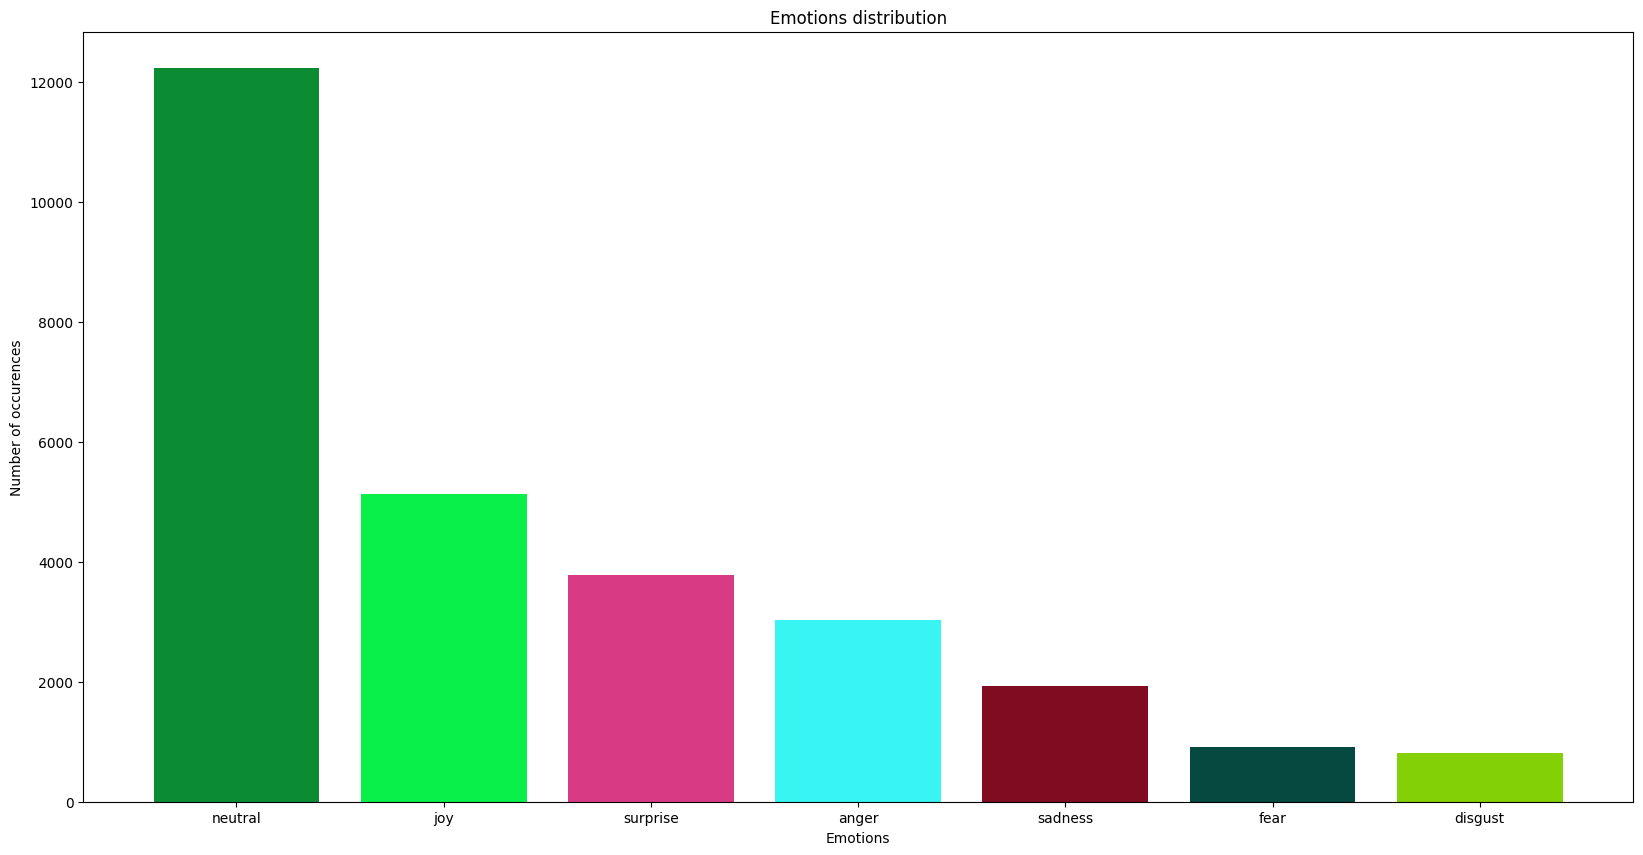

In [9]:
# plot the emotions distribution as histogram
plt.figure(figsize=(20,10))
plt.bar(emotions_dict.keys(), emotions_dict.values(), color=set_color(len(emotions_dict)))
plt.title("Emotions distribution")
plt.xlabel("Emotions")
plt.ylabel("Number of occurences")
plt.show()

As we can see from the plot, the data is not balanced, with the neutral class being the most represented and the disgust class being the least represented. This could lead to problems during the training phase, as the model could be biased towards the neutral class.

We will adress this problem later on in this part of the notebook.

Triggers sorted by occurences:
{0.0: 23524, 1.0: 4289}


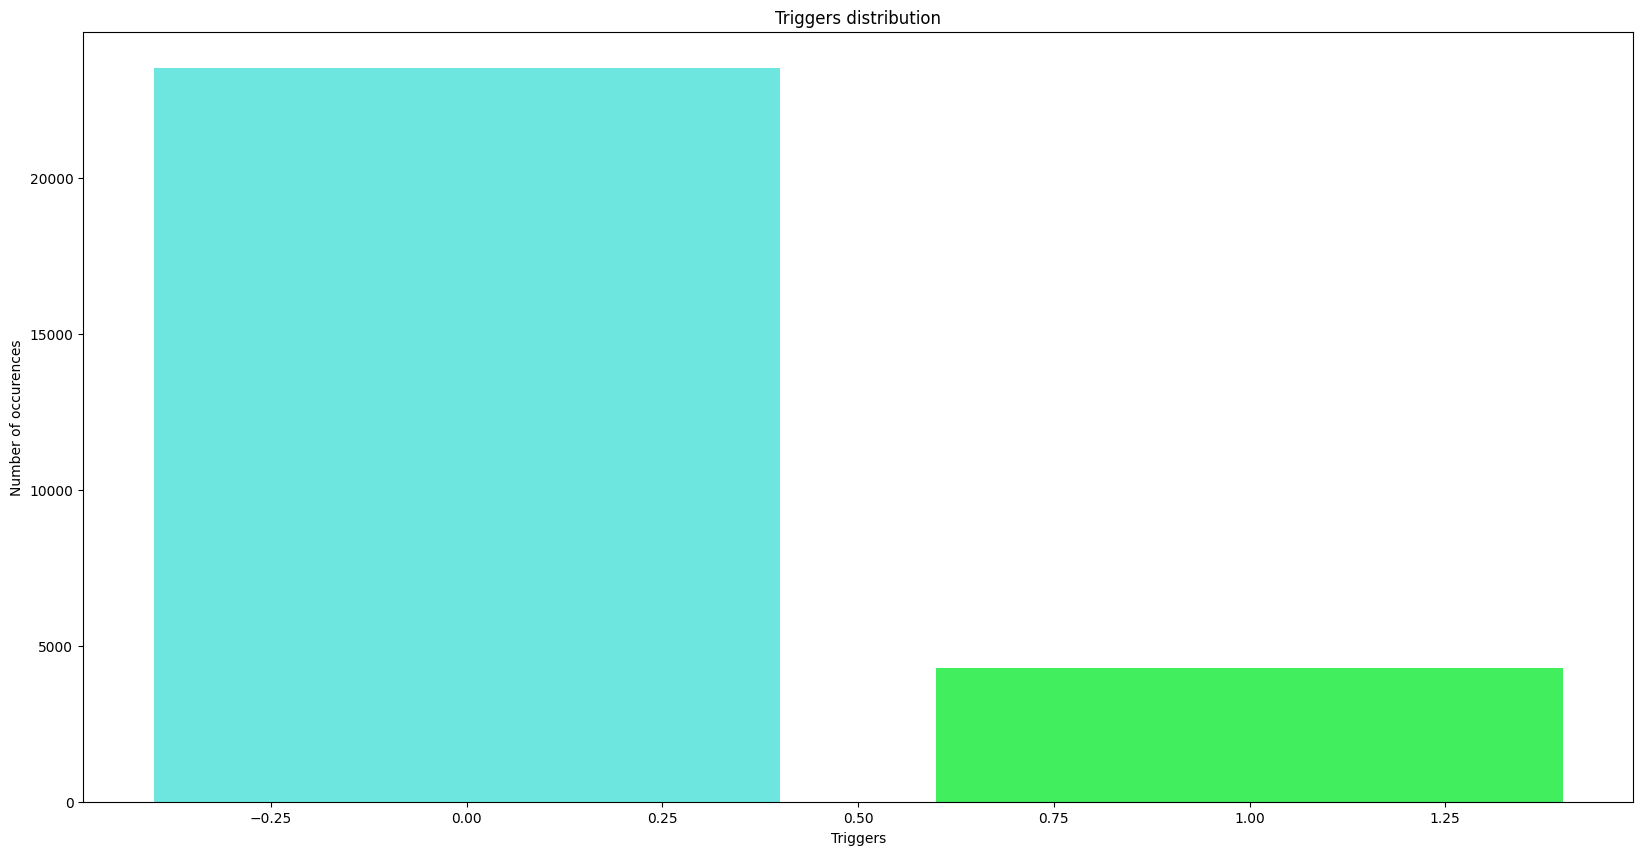

In [10]:
# trigger distribution
trigger_dict = {}
for triggers in df_train["triggers"]:
    for trigger in triggers:
        if trigger in trigger_dict:
            trigger_dict[trigger] += 1
        else:
            trigger_dict[trigger] = 1
        
trigger_dict = {k: v for k, v in sorted(trigger_dict.items(), key=lambda item: item[1], reverse=True)}
print("Triggers sorted by occurences:")
print(trigger_dict)

# plot the triggers distribution as histogram
plt.figure(figsize=(20,10))
plt.bar(trigger_dict.keys(), trigger_dict.values(), color=set_color(len(trigger_dict)))
plt.title("Triggers distribution")
plt.xlabel("Triggers")
plt.ylabel("Number of occurences")
plt.show()

Likewise, we plot the distribution of the trigger labels and we notice that the data is not balanced, with the 0 class being the most represented and the 1 class being the least represented. This could lead to problems during the training phase, as the model could be biased towards the 0 class.

We will adress this problem later on in this part of the notebook.

#### Baseline models:

In [11]:
baseline_train = df_train.copy()
baseline_test = df_test.copy()
baseline_val = df_val.copy()
print("Example of a sample:")
print(baseline_train["utterances"][0])

Example of a sample:
["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.']


We split the utterances into single sentences, likewise the emotions and triggers.

In [12]:
def splitter(df, y_label):
    X = []
    y = []
    for index, row in df.iterrows():
        for i in range(len(row["utterances"])):
            X.append(row["utterances"][i])
            y.append(row[y_label][i])
    return X, y

As the baseline models make prediction based on the label distribution, we won't perform preprocessing on the dataset yet.

In [13]:
# Emotions baseline
x_train_base, y_train_emotions = splitter(baseline_train, "emotions")
x_val_base, y_val_emotions = splitter(baseline_val, "emotions")
x_test_base, y_test_emotions = splitter(baseline_test, "emotions")

# Triggers baseline
_ , y_train_triggers = splitter(baseline_train, "triggers")
_ , y_val_triggers = splitter(baseline_val, "triggers")
_ , y_test_triggers = splitter(baseline_test, "triggers")

print(f"Train shape after splitting: {len(x_train_base)}")
print(f"Val shape after splitting: {len(x_val_base)}")
print(f"Test shape after splitting: {len(x_test_base)}")

print("Example of a sample after splitting: sentence, emotion, trigger")
print(x_train_base[0], y_train_emotions[0], y_train_triggers[0])

Train shape after splitting: 27813
Val shape after splitting: 3571
Test shape after splitting: 3616
Example of a sample after splitting: sentence, emotion, trigger
also I was the point person on my company's transition from the KL-5 to GR-6 system. neutral 0.0


#### BeRT models:

Before proceeding with the preprocessing of the data, we inspect the data in order to visualize different aspects of it.

Max number of sentences: 24


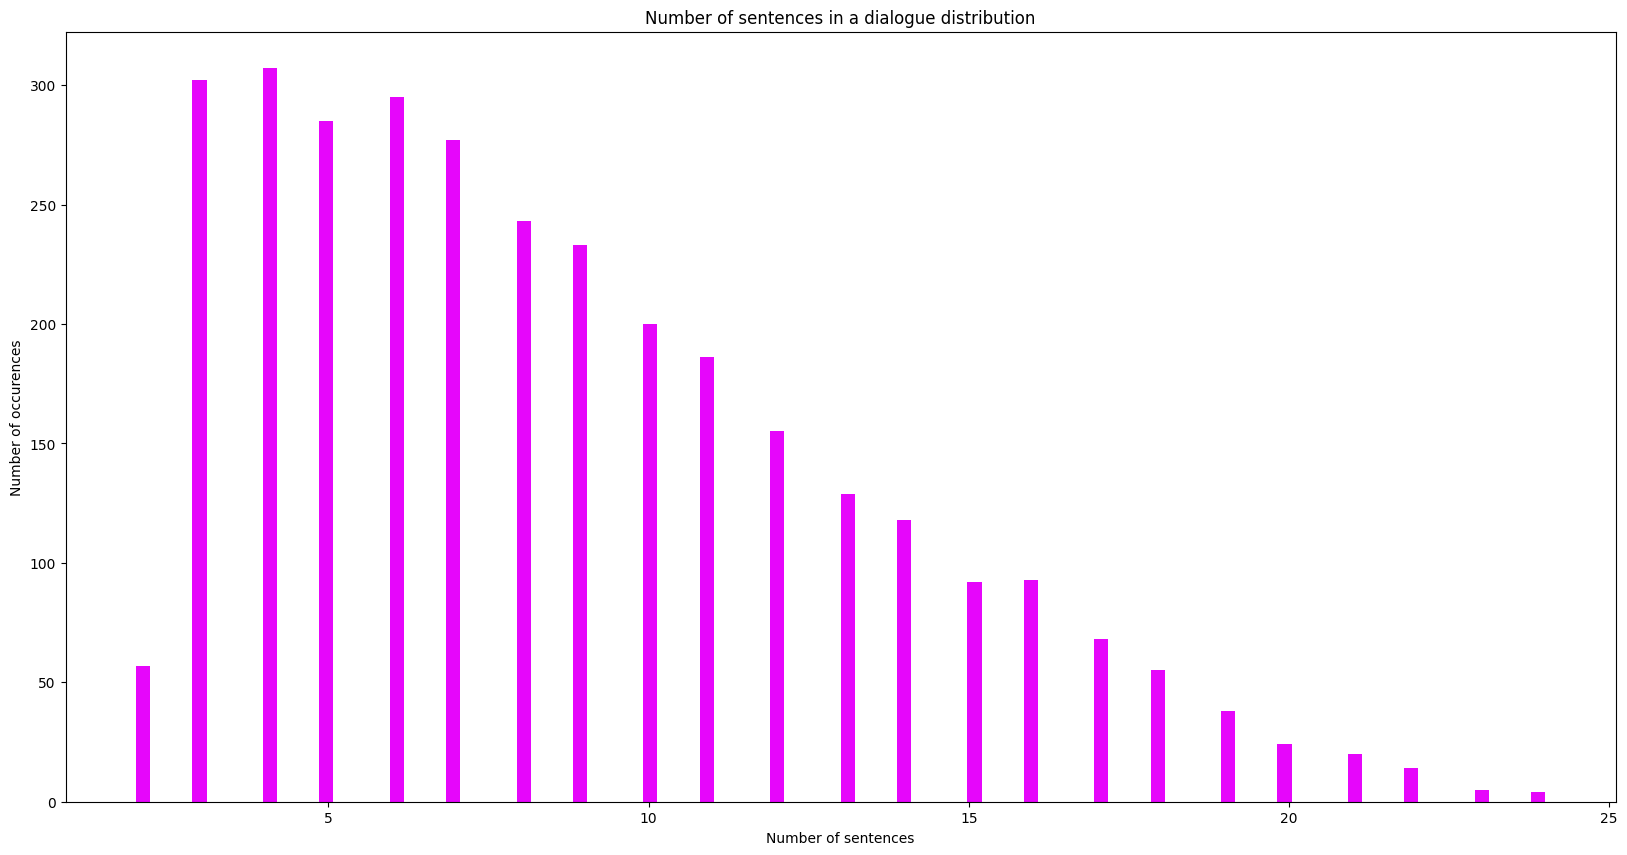

In [14]:
# get number of sentencese distribution
num_sentences = []
for index, row in df_train.iterrows():
    num_sentences.append(len(row["utterances"]))
print(f"Max number of sentences: {max(num_sentences)}")

# Plot number of sentences distribution
plt.figure(figsize=(20,10))
plt.hist(num_sentences, bins=100, color=set_color(1))
plt.title("Number of sentences in a dialogue distribution")
plt.xlabel("Number of sentences")
plt.ylabel("Number of occurences")
plt.show()

This plots show the distribution of the number of sentences per dialogue. We can see that the majority of the dialogues are composed of 10 sentences or less, with a few outliers.

This result while not being useful for the models hyperparameters, it is useful to understand the data and the task, more specifically the fact that the dialogues are short and that the models will have to learn from a small number of sentences. Also, the fact that the dialogues are short made us question the usefulness of the context in the task, as the context is usually used to understand the meaning of the sentence, but in this case the sentences are short and the meaning is usually clear from the sentence itself.

For further tasks we copied the dataframes in order to not modify the original ones.

In [15]:
bert_train = df_train.copy()
bert_val = df_val.copy()
bert_test = df_test.copy()

The first thing we tried was a way to give the model the whole dialogue as we thought that context would be key in helping in the classification task. In order to predict one emotion and trigger at a time we simply repeated the dialogue as many times as the number of sentences in the dialogue, adding the emotion and trigger we were not predicting at the end of the dialogue. This way the model would have the whole dialogue as context and would be able to predict the emotion and trigger for each sentence.

In [16]:
def splitter_bert_context(df):
    columns = ["utterances", "emotions", "triggers", "dialogue"]
    new_df = pd.DataFrame(columns=columns)
    for index in range(df.shape[0]):
        for i, _  in enumerate(df.iloc[index]["utterances"]):
            new_row = pd.DataFrame({"utterances": [df.iloc[index]["utterances"]], "emotions": [df.iloc[index]["emotions"][:i+1]], "triggers": [df.iloc[index]["triggers"][:i+1]], "dialogue": [index]} )
            new_df = pd.concat([new_df, new_row], ignore_index=True)
    return new_df

In [17]:
bert_train_context = splitter_bert_context(bert_train)
bert_val_context = splitter_bert_context(bert_val)
bert_test_context = splitter_bert_context(bert_test)
print(f"Train shape after splitting: {bert_train_context.shape}")
print(f"Val shape after splitting: {bert_val_context.shape}")
print(f"Test shape after splitting: {bert_test_context.shape}")
print("-------------------------------------------------------")
print("Example of a sample: ")
print(bert_train_context.iloc[1])

Train shape after splitting: (27813, 4)
Val shape after splitting: (3571, 4)
Test shape after splitting: (3616, 4)
-------------------------------------------------------
Example of a sample: 
utterances    [also I was the point person on my company's t...
emotions                                     [neutral, neutral]
triggers                                             [0.0, 0.0]
dialogue                                                      0
Name: 1, dtype: object


In [18]:
bert_train_context.head(10)

,utterances,emotions,triggers,dialogue
0,[also I was the point person on my company's t...,[neutral],[0.0],0
1,[also I was the point person on my company's t...,"[neutral, neutral]","[0.0, 0.0]",0
2,[also I was the point person on my company's t...,"[neutral, neutral, neutral]","[0.0, 0.0, 0.0]",0
3,[also I was the point person on my company's t...,"[neutral, neutral, neutral, neutral]","[0.0, 0.0, 0.0, 1.0]",0
4,[also I was the point person on my company's t...,"[neutral, neutral, neutral, neutral, surprise]","[0.0, 0.0, 0.0, 1.0, 0.0]",0
5,[also I was the point person on my company's t...,[neutral],[0.0],1
6,[also I was the point person on my company's t...,"[neutral, neutral]","[0.0, 0.0]",1
7,[also I was the point person on my company's t...,"[neutral, neutral, neutral]","[0.0, 0.0, 0.0]",1
8,[also I was the point person on my company's t...,"[neutral, neutral, neutral, neutral]","[0.0, 0.0, 0.0, 0.0]",1
9,[also I was the point person on my company's t...,"[neutral, neutral, neutral, neutral, surprise]","[0.0, 0.0, 0.0, 0.0, 0.0]",1


Another type of model we started to use after testing the "context" one was a model that would simply predict the emotion and trigger for each sentence without any context. This model would be useful to understand if the context was actually useful in the task. Here's how we preprocessed the data for this model:

In [19]:
def splitter_bert(df):
    columns = ["label", "sentence", "trigger", "dialogue"]
     # split the utteracnes into sentences with their corresponding labels
    new_df = pd.DataFrame(columns=columns)
    for index, row in df.iterrows():
        for i in range(len(row["utterances"])):
            # We also split emotions and triggers while adding back the dialogue index which is the same for all the sentences in the same dialogue
            new_row = pd.DataFrame({"label": [row["emotions"][i]], "sentence": [row["utterances"][i]], "trigger": [row["triggers"][i]], "dialogue": [index]} )
            new_df = pd.concat([new_df, new_row], ignore_index=True)
    return new_df

In [20]:
# split train, val and test sets for BERT
bert_train = splitter_bert(bert_train)
bert_val = splitter_bert(bert_val)
bert_test = splitter_bert(bert_test)
print("Shape of train, val and test sets after splitting: ")
print(f"Train shape: {bert_train.shape}")
print(f"Val shape: {bert_val.shape}")
print(f"Test shape: {bert_test.shape}")
print("-------------------------------------------------------")
print("Example of a sample: ")
print(bert_train.iloc[0])

C:\Users\alepa\AppData\Local\Temp\ipykernel_5196\1202298155.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True)
C:\Users\alepa\AppData\Local\Temp\ipykernel_5196\1202298155.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True)
C:\Users\alepa\AppData\Local\Temp\ipykernel_5196\1202298155.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecate

Shape of train, val and test sets after splitting: 
Train shape: (27813, 4)
Val shape: (3571, 4)
Test shape: (3616, 4)
-------------------------------------------------------
Example of a sample: 
label                                                 neutral
sentence    also I was the point person on my company's tr...
trigger                                                   0.0
dialogue                                                    0
Name: 0, dtype: object


In [21]:
bert_train.head(10) # show first 10 samples of the train set

,label,sentence,trigger,dialogue
0,neutral,also I was the point person on my company's tr...,0.0,0
1,neutral,You must've had your hands full.,0.0,0
2,neutral,That I did. That I did.,0.0,0
3,neutral,So let's talk a little bit about your duties.,1.0,0
4,surprise,My duties? All right.,0.0,0
5,neutral,also I was the point person on my company's tr...,0.0,1
6,neutral,You must've had your hands full.,0.0,1
7,neutral,That I did. That I did.,0.0,1
8,neutral,So let's talk a little bit about your duties.,0.0,1
9,surprise,My duties? All right.,0.0,1


We create dictionaries to map the one-hot encoded labels to the original labels and vice versa.

We also keep track of an integer index for the emotions.

In [22]:
# one hot encode the emotions
emotions_one_hot_dict = {
    "neutral": [1, 0, 0, 0, 0, 0, 0],
    "joy": [0, 1, 0, 0, 0, 0, 0],
    "surprise": [0, 0, 1, 0, 0, 0, 0],
    "sadness": [0, 0, 0, 1, 0, 0, 0],
    "anger": [0, 0, 0, 0, 1, 0, 0],
    "disgust": [0, 0, 0, 0, 0, 1, 0],
    "fear": [0, 0, 0, 0, 0, 0, 1]
}

In [23]:
# one hot encode the triggers
triggers_one_hot_dict = {
    0: [1, 0],
    1: [0, 1]
}

In [24]:
emotion_to_index = {
    "neutral": 0,
    "joy": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "disgust": 5,
    "fear": 6
}

In [25]:
index_to_emotion = {
    0: "neutral",
    1: "joy",
    2: "surprise",
    3: "sadness",
    4: "anger",
    5: "disgust",
    6: "fear"
}

Now that every utterance is split into sentences, we can proceed by visualizing the distribution of the number of words per sentence.

Max sentence length: 327


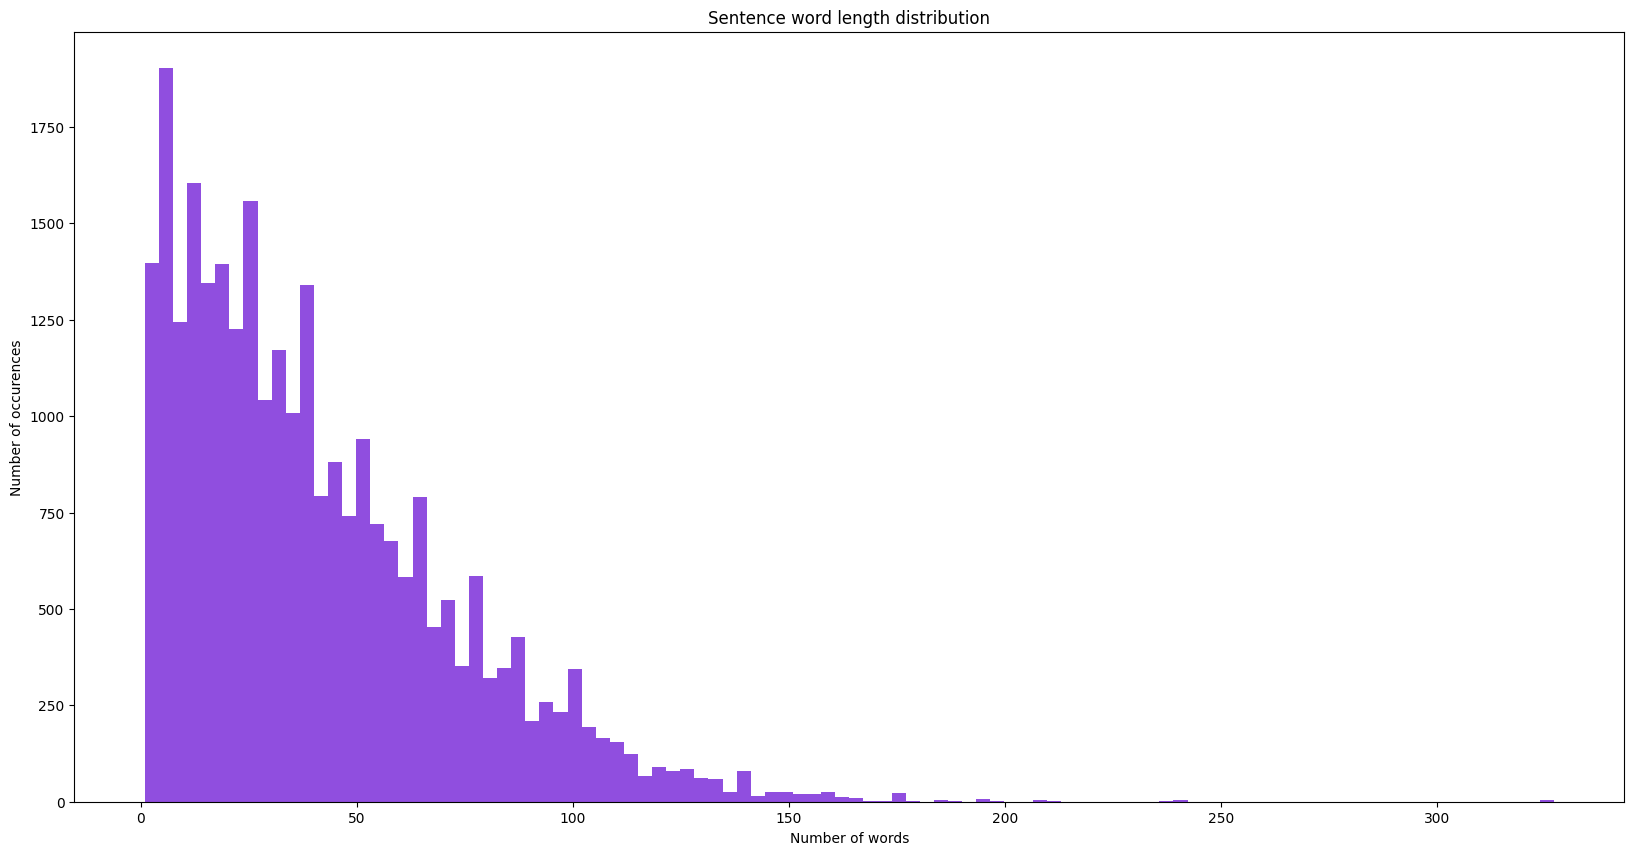

In [26]:
# plot sentence word length distribution
sentence_length = []
for index, row in bert_train.iterrows():
    sentence_length.append(len(row["sentence"]))
print(f"Max sentence length: {max(sentence_length)}")

plt.figure(figsize=(20,10))
plt.hist(sentence_length, bins=100, color=set_color(1))
plt.title("Sentence word length distribution")
plt.xlabel("Number of words")
plt.ylabel("Number of occurences")
plt.show()

As we can see from the plot, the majority of the sentences have a length of 10, wuth a few outliers. This is useful as it helps us decide the maximum length of the padding for the sentences.

As we use a BeRT uncased model its tokenizer will do all the preprocessing for us, so we do not need to do any preprocessing on the sentences. We need to only define hyperparameters such as the maximum length of the sentences and the batch size.

In [27]:
MODEL_NAME = 'bert-base-uncased'
#MODEL_NAME = "prajjwal1/bert-tiny"

MAX_LEN = 360 # To be safe even though the max length is 327
BATCH_SIZE = 1 # can be increased if memory allows it
EPOCHS = 2 #1 for fast testing
LEARNING_RATE = 2e-05
OUT_CHANNELS = 768 if "base" in  MODEL_NAME else 128 #128 if "tiny" 1024 if "base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

BeRT models need custom datasets and dataloaders, so we define them as follows:

We also present the code for the custom dataset and dataloader for the BeRT models with context. We tokenize the whole utternace and provide the emotions and triggers we are not predicting concatenated at the end of the utterance. 

In [28]:
class CustomDatasetContext(Dataset):

    def __init__(self, data, tokenizer, max_len, is_test=False):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        utterance = row["utterances"]
        emotions = row["emotions"]
        triggers = row["triggers"]
        dialogue = row["dialogue"]
        target_emotion = emotions_one_hot_dict[emotions[-1]]
        target_trigger = triggers_one_hot_dict[triggers[-1]]

        text = " "
        for i in range(len(utterance)):
            text = text + f"{utterance[i]}"

        if not self.is_test:
            text = text + " emotions: "
            for i in range(len(emotions)-1):
                text = text + f"{emotions[i]}"

            text = text + " triggers: "
            for i in range(len(triggers)-1):
                text = text + f"{triggers[i]}" 

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding="max_length",
            truncation=True,
        )

        input_ids = encoding["input_ids"]
        attention_mask = encoding["attention_mask"]
        token_type_ids = encoding["token_type_ids"]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_emotion": torch.tensor(target_emotion, dtype=torch.float),
            "target_trigger": torch.tensor(target_trigger, dtype=torch.float),
            "dialogue": dialogue
        }

In [29]:
train_dataset_context = CustomDatasetContext(bert_train_context, tokenizer, MAX_LEN)
val_dataset_context = CustomDatasetContext(bert_val_context, tokenizer, MAX_LEN, is_test=True)
test_dataset_context = CustomDatasetContext(bert_test_context, tokenizer, MAX_LEN, is_test=True)

train_loader_context = DataLoader(train_dataset_context, batch_size=BATCH_SIZE, shuffle=True)
val_loader_context = DataLoader(val_dataset_context, batch_size=BATCH_SIZE, shuffle=False)
test_loader_context = DataLoader(test_dataset_context, batch_size=BATCH_SIZE, shuffle=False)

Example of a tokenized and padded sentence:

In [30]:
train_dataset_context[0]

{'input_ids': tensor([  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,  2194,
          1005,  1055,  6653,  2013,  1996,  1047,  2140,  1011,  1019,  2000,
         24665,  1011,  1020,  2291,  1012,  2017,  2442,  1005,  2310,  2018,
          2115,  2398,  2440,  1012,  2008,  1045,  2106,  1012,  2008,  1045,
          2106,  1012,  2061,  2292,  1005,  1055,  2831,  1037,  2210,  2978,
          2055,  2115,  5704,  1012,  2026,  5704,  1029,  2035,  2157,  1012,
          6699,  1024, 27099,  1024,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

For the dataset we tokenize the sentences and pad them to the maximum length while also passing the target emotion and trigger label one-hot encoded.

Dialogue index is also returned as it is needed for the evaluation phase.

This dataset is used for the model without context.

In [31]:
class CustomDataset(Dataset):

    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = data
        self.text = data.sentence
        self.emotions = data.label
        self.max_len = max_len
        self.triggers = data.trigger
        self.dialogue = data.dialogue

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        #speakers = row["speakers"]
        text = row["sentence"]
        emotions = row["label"]
        trigger = row["trigger"]
        dialogue = row["dialogue"]
        target_emotion = emotions_one_hot_dict[emotions] #+ [triggers[-1]] # trigger is float while emotions are one hot encoded but as integers IN CASE OF ERROR CHECK THIS
        target_trigger = triggers_one_hot_dict[trigger]


        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'label': torch.tensor(target_emotion, dtype=torch.float),
            'trigger': torch.tensor(target_trigger, dtype=torch.float),
            'dialogue': dialogue
        }

For the dataloader we simply use the default one.

In [32]:
train_dataset = CustomDataset(bert_train, tokenizer, MAX_LEN)
val_dataset = CustomDataset(bert_val, tokenizer, MAX_LEN)
test_dataset = CustomDataset(bert_test, tokenizer, MAX_LEN)

# Definiition of the Dataloader that will feed the data in batches to the neural network for suitable training and processing.
training_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Example of a tokenized and padded sentence:

In [33]:
train_dataset[0]

{'input_ids': tensor([  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,  2194,
          1005,  1055,  6653,  2013,  1996,  1047,  2140,  1011,  1019,  2000,
         24665,  1011,  1020,  2291,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

## Model definitions:


As we present two different macro type of models, we will define the models in two different ways. For the baseline models we simply use dummy classifiers with random uniform and majority strategies. For the BeRT models we use the BeRT architecture with an additional multihead classifier layers.

Defining the dummy classifier for emotions and triggers:

In [34]:
dummy_clf_majority_emotions = DummyClassifier(strategy="most_frequent")
dummy_clf_random_emotions = DummyClassifier(strategy="uniform")

dummy_clf_majority_triggers = DummyClassifier(strategy="most_frequent")
dummy_clf_random_triggers = DummyClassifier(strategy="uniform")

Defining the BeRT model for emotions and triggers:

The model is simply composed by BeRT, which functions as an encoder, and a multihead classifier. We decided on multihead classifier as it is a simple and effective way to classify the emotions and triggers separately, as the two tasks are related but not the same. (Previous trials with a single classifier for both tasks did not yield good results)

The two classifiers are composed by a dropout layer, to avoid overfitting, and a linear layer in order to classify the emotions and triggers.

In [35]:
class BERTClass(torch.nn.Module):
    def __init__(self,model):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        # Emotions
        self.l2 = torch.nn.Dropout(p=0.3)
        self.l3 = torch.nn.Linear(OUT_CHANNELS, 7)
        # Triggers
        self.l4 = torch.nn.Dropout(p=0.3)
        self.l5 = torch.nn.Linear(OUT_CHANNELS, 2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_emotions = self.l2(output_1)
        output_emotions = self.l3(output_emotions)
        output_trigger = self.l4(output_1)
        output_trigger = self.l5(output_trigger)
        return output_emotions, output_trigger

We instantiate a different model for the context dataset in order to compare the results further on.

In [36]:
model_context = BERTClass(MODEL_NAME)
model_context.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In order to use the "Frozen" model we simply freeze the BeRT encoder and train only the multihead classifier.

In [37]:
model = BERTClass(MODEL_NAME)

# FROZEN BERT
for name, param in model.named_parameters():
     if name.startswith("l1"): # choose whatever you like here
        param.requires_grad = False

model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

## Evaluation metrics:

Here we define the evaluation metrics used for the models.

### Baseline models:

Evaluation function that returns the classification report:

In [38]:
def evaluate(Y_test, Y_pred):
    report = classification_report(Y_test, Y_pred, zero_division=0)
    return report

### BeRT models:

In order to evaluate the BeRT models we use the same metrics as the baseline models, mainly focusing on the weighted average F1 score.

One difference is that we also try to rebalance the classes by using the class weights in the loss function. This is done in order to see if the models can learn better from the data and thus improve the results.

We do this for both the emotions and the triggers.

In [39]:
#compute class weights based on distribution of classes in training set
y_train = []
for index, row in df_train.iterrows():
    for i in range(len(row["utterances"])):
        y_train.append(row["emotions"][i])
class_weights_emotions = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights_emotions}")
class_weights_emotions = torch.tensor(class_weights_emotions, dtype=torch.float)

Class weights: [1.31348288 4.86922269 4.3329179  0.77557793 0.32493341 2.0597645
 1.05252602]


In [40]:
y_train = []
for index, row in df_train.iterrows():
    for i in range(len(row["utterances"])):
        y_train.append(row["triggers"][i])
class_weights_triggers = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights_triggers}")
class_weights_triggers = torch.tensor(class_weights_triggers, dtype=torch.float)

Class weights: [0.59116222 3.24236419]


Here is the custom loss function:

As we use a multihead classifier, we need to define the loss function for both the emotions and the triggers. 

Emotions loss function: cross entropy loss with class weights.
Triggers loss function: binary cross entropy loss with class weights.

The overall loss is the sum of the two losses.

In [41]:
def compute_loss(output_emotion, output_trigger, targets_emotion, targets_trigger):
    label_emotion = targets_emotion
    label_trigger = targets_trigger
    # compute custom loss 
    loss_fct_emo = torch.nn.CrossEntropyLoss(weight=class_weights_emotions.clone().detach().to(device))
    loss = loss_fct_emo(output_emotion, label_emotion)
    loss_fct_targ = torch.nn.BCEWithLogitsLoss(weight=class_weights_triggers.clone().detach().to(device))
    loss += loss_fct_targ(output_trigger, label_trigger)
    return loss

Here we also define a loss function without class weights, in order to compare results with and without class weights in the last part of the notebook.

In [42]:
def compute_loss_no_weights(output_emotion, output_trigger, targets_emotion, targets_trigger):
    label_emotion = targets_emotion
    label_trigger = targets_trigger
    # compute custom loss 
    loss_fct_emo = torch.nn.CrossEntropyLoss()
    loss = loss_fct_emo(output_emotion, label_emotion)
    loss_fct_targ = torch.nn.BCEWithLogitsLoss()
    loss += loss_fct_targ(output_trigger, label_trigger)
    return loss


We also define the inference function for the BeRT models:

In [43]:
def inference_context(model, test_load):
    model.eval()
    fin_targets_emotion = []
    fin_outputs_emotion = []
    fin_outputs_trigger = []
    fin_targets_trigger = []

    dialogue_lengths = []

    current_dialogue = test_load.dataset.data.iloc[0]["dialogue"]
    length_current_dialogue = 0

    with torch.no_grad():
        for batch, data in enumerate(test_load, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            target_emotion = data['target_emotion'].to(device, dtype = torch.float)
            target_trigger = data['target_trigger'].to(device, dtype = torch.float)
            dialogue = data['dialogue']
            output_emotion, output_trigger = model(ids, mask, token_type_ids)

            if dialogue == current_dialogue:
                length_current_dialogue += 1
            else:
                dialogue_lengths.append(length_current_dialogue)
                length_current_dialogue = 1
                current_dialogue = dialogue

            fin_targets_emotion.extend(torch.argmax(target_emotion, axis=1).cpu().detach().numpy().tolist())
            fin_outputs_emotion.extend(torch.argmax(output_emotion, axis=1).cpu().detach().numpy().tolist())
            fin_outputs_trigger.extend(torch.sigmoid(output_trigger).cpu().detach().numpy().tolist())
            fin_targets_trigger.extend(target_trigger.cpu().detach().numpy().tolist())
        
    return fin_outputs_emotion, fin_targets_emotion, fin_outputs_trigger, fin_targets_trigger, dialogue_lengths

For the emotions we use the argmax function to get the most probable emotion from the output of the model. For the triggers we use a sigmoid function to get the most probable trigger from the output of the model.

In [44]:
def inference(model, test_load):
    model.eval()
    fin_targets_emotion = []
    fin_outputs_emotion = []
    fin_outputs_trigger = []

    dialogue_lengths = []

    current_dialogue = test_load.dataset.data.iloc[0]["dialogue"]
    length_current_dialogue = 0

    with torch.no_grad():
        for batch, data in enumerate(test_load, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            target_emotion = data['label'].to(device, dtype = torch.float)
            target_trigger = data['trigger'].to(device, dtype = torch.float)
            dialogue = data['dialogue']
            output_emotion, output_trigger = model(ids, mask, token_type_ids)
            
            if dialogue == current_dialogue:
                length_current_dialogue += 1
            else:
                dialogue_lengths.append(length_current_dialogue)
                length_current_dialogue = 1
                current_dialogue = dialogue

            fin_targets_emotion.extend(torch.argmax(target_emotion, axis=1).cpu().detach().numpy().tolist())
            fin_outputs_emotion.extend(torch.argmax(output_emotion, axis=1).cpu().detach().numpy().tolist())
            fin_outputs_trigger.extend(torch.sigmoid(output_trigger).cpu().detach().numpy().tolist())
        
    return fin_outputs_emotion, fin_targets_emotion, fin_outputs_trigger, dialogue_lengths

The trigger_max function is used to get the most probable trigger from the output of the model.

In [45]:
def trigger_max(outputs):
    temp = []
    for elem in outputs:
        if elem[0] > elem[1]:
            temp.append(0)
        else:
            temp.append(1)
    
    return temp

The RMSE function is used to calculate the root mean squared error between the predicted and the true trigger in order to find the standard deviation of the predictions.

In [46]:
from sklearn.metrics import mean_squared_error

def get_rmse(targets, outputs):
    return mean_squared_error(targets, outputs, squared=False)

## Training and evaluation:

Training and evaluation of the baseline classifiers fitted on the training set:

In [47]:
# Emotions baseline
dummy_clf_majority_emotions.fit(x_train_base, y_train_emotions)
dummy_clf_random_emotions.fit(x_train_base, y_train_emotions)

y_pred_majority_emotions = dummy_clf_majority_emotions.predict(x_test_base)
y_pred_random_emotions = dummy_clf_random_emotions.predict(x_test_base)
print("Majority classifier for emotions: \n")
print(evaluate(y_test_emotions, y_pred_majority_emotions))
print("-------------------------------------------------------")
print("Random classifier for emotions: \n")
print(evaluate(y_test_emotions, y_pred_random_emotions))
print("-------------------------------------------------------")

# Triggers baseline
dummy_clf_majority_triggers.fit(x_train_base, y_train_triggers)
dummy_clf_random_triggers.fit(x_train_base, y_train_triggers)

y_pred_majority_triggers = dummy_clf_majority_triggers.predict(x_test_base)
y_pred_random_triggers = dummy_clf_random_triggers.predict(x_test_base)
print("Majority classifier for triggers: \n")
print(evaluate(y_test_triggers, y_pred_majority_triggers))
print("-------------------------------------------------------")
print("Random classifier for triggers: \n")
print(evaluate(y_test_triggers, y_pred_random_triggers))

Majority classifier for emotions: 

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       478
     disgust       0.00      0.00      0.00       145
        fear       0.00      0.00      0.00        71
         joy       0.00      0.00      0.00       603
     neutral       0.42      1.00      0.59      1522
     sadness       0.00      0.00      0.00       365
    surprise       0.00      0.00      0.00       432

    accuracy                           0.42      3616
   macro avg       0.06      0.14      0.08      3616
weighted avg       0.18      0.42      0.25      3616

-------------------------------------------------------
Random classifier for emotions: 

              precision    recall  f1-score   support

       anger       0.15      0.16      0.16       478
     disgust       0.03      0.12      0.05       145
        fear       0.01      0.10      0.02        71
         joy       0.19      0.16      0.17       603
     n

As we can see from the results, the random uniform strategy performs poorly on both the emotions and the triggers, while the majority strategy performs better on the emotions and on the triggers.

We strongly believe that the majority strategy performs better on the triggers because the data is imbalanced, with the 0 class being the most represented and the 1 class being the least represented. This could lead to problems during the training phase, as the model could be biased towards the 0 class. Same thing for the emotions.

### BeRT model:

First we define the optimizer and the scheduler for the BeRT model. As an optimizer we use Adam as we prefer it over others. As a scheduler we use a linear scheduler with warmup, as it is the one that gave us the best results.

In [48]:
optimizer_context = torch.optim.Adam(params =  model_context.parameters(), lr=LEARNING_RATE)
scheduler_context = to.lr_scheduler.StepLR(optimizer_context, step_size=1, gamma=0.6)
#scheduler_context = get_linear_schedule_with_warmup(optimizer_context, num_warmup_steps=(0.1*(len(train_loader_context))*EPOCHS), num_training_steps=len(train_loader_context)*EPOCHS)

In [49]:
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
scheduler = to.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.6)
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=(0.1*(len(training_loader))*EPOCHS), num_training_steps=len(training_loader)*EPOCHS)

The training loop for the BeRT model is defined as follows:

We train the model for a number of epochs, in this case 5, and we evaluate it after each epoch. We also save the model with the best results. 

As we are currently using a batch size of 1 we only present the result every 5000 steps, just for visualization purposes.

In [50]:
def train_context(model_context, class_weights=True):
    size = len(train_loader_context.dataset)
    model_context.train()
    for batch,data in enumerate(train_loader_context, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        target_emotion = data['target_emotion'].to(device, dtype = torch.float)
        target_trigger = data['target_trigger'].to(device, dtype = torch.float)
        
        output_emotion, output_trigger = model_context(ids, mask, token_type_ids)
        if class_weights:
            loss = compute_loss(output_emotion, output_trigger, target_emotion, target_trigger)
        else:
            loss = compute_loss_no_weights(output_emotion, output_trigger, target_emotion, target_trigger)

        # Backpropagation
        optimizer_context.zero_grad()
        loss.backward()
        optimizer_context.step()
        #scheduler_context.step()

        if batch%5000==0:
            current =  batch * len(data['input_ids'])
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

In [51]:
def train(model, optimizer, scheduler, class_weights=True):
    size = len(training_loader.dataset)
    model.train()
    for batch,data in enumerate(training_loader, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        target_emotion = data['label'].to(device, dtype = torch.float)
        target_trigger = data['trigger'].to(device, dtype = torch.float)
        
        output_emotion, output_trigger = model(ids, mask, token_type_ids)
        if class_weights:
            loss = compute_loss(output_emotion, output_trigger, target_emotion, target_trigger)
        else:
            loss = compute_loss_no_weights(output_emotion, output_trigger, target_emotion, target_trigger)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()

        if batch%5000==0:
            current =  batch * len(data['input_ids'])
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

Validation is done on the validation set and is similar to the training loop, with the difference that we do not update the weights of the model.

In [52]:
def validation_context(model_context, epoch, val_loss_min_input, class_weights=True):
    num_batches = len(val_loader_context)
    model_context.eval()
    val_loss = 0
    with torch.no_grad():
        for batch, data in enumerate(val_loader_context, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            target_emotion = data['target_emotion'].to(device, dtype = torch.float)
            target_trigger = data['target_trigger'].to(device, dtype = torch.float)

            output_emotion, output_target = model_context(ids, mask, token_type_ids)
            if class_weights:
                val_loss += compute_loss(output_emotion, output_target, target_emotion, target_trigger).item()
            else:
                val_loss += compute_loss_no_weights(output_emotion, output_target, target_emotion, target_trigger).item()

        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        print(f"\nValidation loss: {val_loss:>8f}.")
        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            #create checkpoint variable and add important data
            if epoch > 0:
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else: print('Saving model ...')
            # save best moel
            torch.save(model_context.state_dict(), "model_bert_standard_project.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss

    return val_loss_min_input

In [53]:
def validation(model, epoch, val_loss_min_input, class_weights=True):
    num_batches = len(val_loader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch, data in enumerate(val_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            target_emotion = data['label'].to(device, dtype = torch.float)
            target_trigger = data['trigger'].to(device, dtype = torch.float)

            output_emotion, output_target = model(ids, mask, token_type_ids)
            if class_weights:
                val_loss += compute_loss(output_emotion, output_target, target_emotion, target_trigger).item()
            else:
                val_loss += compute_loss_no_weights(output_emotion, output_target, target_emotion, target_trigger).item()

        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        print(f"\nValidation loss: {val_loss:>8f}.")
        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            #create checkpoint variable and add important data
            if epoch > 0:
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else: print('Saving model ...')
            # save best moel
            torch.save(model.state_dict(), "model_bert_standard_project.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss

    return val_loss_min_input

### BeRT model training:

Model with context:

In [54]:
val_loss_min = np.Inf
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_context(model_context, class_weights=True)
    scheduler_context.step()
    val_loss_min = validation_context(model_context, epoch, val_loss_min, class_weights=True)

Epoch 1
-------------------------------


Train loss: 3.756198  [    0/27813]
Train loss: 1.781180  [ 5000/27813]
Train loss: 1.641445  [10000/27813]
Train loss: 1.840197  [15000/27813]
Train loss: 2.122973  [20000/27813]
Train loss: 4.505935  [25000/27813]

Validation loss: 4.037110.
Saving model ...
Saved PyTorch Model State to model.pth

Epoch 2
-------------------------------
Train loss: 4.819886  [    0/27813]
Train loss: 2.549111  [ 5000/27813]
Train loss: 5.334248  [10000/27813]
Train loss: 2.288494  [15000/27813]
Train loss: 2.281630  [20000/27813]
Train loss: 2.206180  [25000/27813]

Validation loss: 4.025382.
Validation loss decreased (4.03711005 --> 4.02538223).  Saving model ...
Saved PyTorch Model State to model.pth



Model without context:

In [55]:
val_loss_min_st = np.inf
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(model, optimizer=optimizer, scheduler=scheduler, class_weights=True)
    scheduler.step()
    val_loss_min_st = validation(model, epoch, val_loss_min_st, class_weights=True)

Epoch 1
-------------------------------
Train loss: 4.831499  [    0/27813]
Train loss: 4.788110  [ 5000/27813]
Train loss: 1.778491  [10000/27813]
Train loss: 2.037405  [15000/27813]
Train loss: 1.944159  [20000/27813]
Train loss: 2.625781  [25000/27813]

Validation loss: 3.775789.
Saving model ...
Saved PyTorch Model State to model.pth

Epoch 2
-------------------------------
Train loss: 1.829603  [    0/27813]
Train loss: 4.238266  [ 5000/27813]
Train loss: 1.932783  [10000/27813]
Train loss: 2.095084  [15000/27813]
Train loss: 2.515703  [20000/27813]
Train loss: 2.363777  [25000/27813]

Validation loss: 3.624036.
Validation loss decreased (3.77578894 --> 3.62403626).  Saving model ...
Saved PyTorch Model State to model.pth



Evaluation of the BeRT models:

In order to evaluate the BeRT models we use the same metrics as the baseline models, but propose two different approaches. The first approach is to use the model as it is, with the dialogues unrolled into sentences. The second approach is to consider results based on the dialogues, as to get a more realistic evaluation of the model.

### Unrolled sentences:

Model with context:

In [56]:
outputs_emotion_context, targets_emotion_context, outputs_trigger_context, targets_trigger_context, dialogue_lengths_context = inference_context(model_context, test_loader_context)
targets_trigger_context = trigger_max(targets_trigger_context)
outputs_trigger_context = trigger_max(outputs_trigger_context)

In [57]:
report_triggers_context = classification_report(targets_trigger_context, outputs_trigger_context, zero_division=0)
report_emotions_context = classification_report(targets_emotion_context, outputs_emotion_context, zero_division=0)
print("Report for triggers: \n")
print(report_triggers_context)
print("-------------------------------------------------------")
print("Report for emotions: \n")
print(report_emotions_context)

Report for triggers: 

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3088
           1       0.00      0.00      0.00       528

    accuracy                           0.85      3616
   macro avg       0.43      0.50      0.46      3616
weighted avg       0.73      0.85      0.79      3616

-------------------------------------------------------
Report for emotions: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1522
           1       0.17      1.00      0.29       603
           2       0.00      0.00      0.00       432
           3       0.00      0.00      0.00       365
           4       0.00      0.00      0.00       478
           5       0.00      0.00      0.00       145
           6       0.00      0.00      0.00        71

    accuracy                           0.17      3616
   macro avg       0.02      0.14      0.04      3616
weighted avg       0.03      

In [58]:
rmse_triggers_context = get_rmse(targets_trigger_context, outputs_trigger_context)
rmse_emotions_context = get_rmse(targets_emotion_context, outputs_emotion_context)
print(f"RMSE for triggers: {rmse_triggers_context}")
print(f"RMSE for emotions: {rmse_emotions_context}")

RMSE for triggers: 0.38212262313954176
RMSE for emotions: 1.8072953194432326


In [59]:
# get macro and weighted f1 scores
macro_f1_score_triggers_context = f1_score(targets_trigger_context, outputs_trigger_context, average="macro")
weighted_f1_score_triggers_context = f1_score(targets_trigger_context, outputs_trigger_context, average="weighted")

macro_f1_score_emotions_context = f1_score(targets_emotion_context, outputs_emotion_context, average="macro")
weighted_f1_score_emotions_context = f1_score(targets_emotion_context, outputs_emotion_context, average="weighted")

We get the results for the emotions and the triggers separately.

Model without context:

In [60]:
outputs_emotion, targets_emotion, outputs_trigger, dialogue_lengths = inference(model, test_loader)
targets_trigger = bert_test["trigger"].tolist()
trigger_max_pred = trigger_max(outputs_trigger)

In [61]:
report_triggers = classification_report(targets_trigger, trigger_max_pred,zero_division=0)
report_emotions = classification_report(targets_emotion, outputs_emotion, target_names=emotion_to_index.keys(), zero_division=0)
print("Report for triggers: \n")
print(report_triggers)
print("-------------------------------------------------------")
print("Report for emotions: \n")
print(report_emotions)

Report for triggers: 

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      3088
         1.0       0.00      0.00      0.00       528

    accuracy                           0.85      3616
   macro avg       0.43      0.50      0.46      3616
weighted avg       0.73      0.85      0.79      3616

-------------------------------------------------------
Report for emotions: 

              precision    recall  f1-score   support

     neutral       0.56      0.84      0.67      1522
         joy       0.29      0.36      0.32       603
    surprise       0.37      0.49      0.42       432
     sadness       0.00      0.00      0.00       365
       anger       0.00      0.00      0.00       478
     disgust       0.00      0.00      0.00       145
        fear       0.00      0.00      0.00        71

    accuracy                           0.47      3616
   macro avg       0.17      0.24      0.20      3616
weighted avg       0.33      

In [62]:
rmse_triggers = get_rmse(targets_trigger, trigger_max_pred)
print(f"RMSE for triggers: {rmse_triggers}")

rmse_emotions = get_rmse(targets_emotion, outputs_emotion)
print(f"RMSE for emotions: {rmse_emotions}")

RMSE for triggers: 0.38212262313954176
RMSE for emotions: 1.9902277852467394


In [63]:
macro_f1_score_emotions = f1_score(targets_emotion, outputs_emotion, average="macro")
weighted_f1_score_emotions = f1_score(targets_emotion, outputs_emotion, average="weighted")

macro_f1_score_triggers = f1_score(targets_trigger, trigger_max_pred, average="macro")
weighted_f1_score_triggers = f1_score(targets_trigger, trigger_max_pred, average="weighted")

As we can see from the results, the models perform way better than the baseline models. One important thing to notice is that is can actually classify even emotions that are hardly represented in the data, such as disgust, which is something that neither the baseline models nor previous trials without class weights were able to do.

The santandard deviation of the emotion prediction is higher than the one of the trigger prediction, which is expected as the emotions are more complex than the triggers.

Further result exploration is done in the last part of the notebook.

### Sequences of dialogues: 

Instead of computing single predictions and metrics we also consider the fact that single sentences are part of a dialogue.

Here we make use of the dialogue index that we saved during the dataset creation phase.

In [64]:
def get_dialogue_preds(outputs_emotion, targets_emotion, outputs_trigger, targets_trigger, dialogue_lengths):
    current_index = 0
    dialogue_predictions_emotions = []
    dialogue_targets_emotions = []
    dialogue_predictions_triggers = []
    dialogue_targets_triggers = []
    for length in dialogue_lengths:
        dialogue_predictions_emotions.append(outputs_emotion[current_index:current_index+length])
        dialogue_targets_emotions.append(targets_emotion[current_index:current_index+length])
        dialogue_predictions_triggers.append(outputs_trigger[current_index:current_index+length])
        dialogue_targets_triggers.append(targets_trigger[current_index:current_index+length])
        current_index += length
    
    return dialogue_predictions_emotions, dialogue_targets_emotions, dialogue_predictions_triggers, dialogue_targets_triggers

In [65]:
def f1_score_per_dialogue(dialogue_predictions_emotions, dialogue_targets_emotions, dialogue_predictions_triggers, dialogue_targets_triggers):
    f1_scores_emotions = []
    f1_scores_triggers = []
    for i in range(len(dialogue_predictions_emotions)):
        f1_scores_emotions.append(f1_score(dialogue_targets_emotions[i], dialogue_predictions_emotions[i], average='macro'))
        f1_scores_triggers.append(f1_score(dialogue_targets_triggers[i], dialogue_predictions_triggers[i], average='macro'))
    return f1_scores_emotions, f1_scores_triggers

In [66]:
def rmse_per_dialogue(f1_scores):
    rmse_scores = []
    for i in range(len(f1_scores)):
        rmse_scores.append(np.sqrt(((f1_scores[i] - np.mean(f1_scores)) ** 2)))
    return rmse_scores

We compute the predictions for each sentence and then we group them by dialogue index. We also compute emotion and trigger predictions for each dialogue separately.

In order to compute a dialogue prediction we use simply use the mean of the predictions of the sentences that compose the dialogue.

Model with context:

In [67]:
dialogue_predictions_emotions_context, dialogue_targets_emotions_context, dialogue_predictions_triggers_context, dialogue_targets_triggers_context = get_dialogue_preds(outputs_emotion_context, targets_emotion_context, outputs_trigger_context, targets_trigger_context, dialogue_lengths_context)

In [68]:
f1_scores_emotions_context, f1_scores_triggers_context = f1_score_per_dialogue(dialogue_predictions_emotions_context, dialogue_targets_emotions_context, dialogue_predictions_triggers_context, dialogue_targets_triggers_context)
print(f"Average F1 score per dialogue for emotions: {np.mean(f1_scores_emotions_context)}")
print(f"Average F1 score per dialogue for triggers: {np.mean(f1_scores_triggers_context)}")

Average F1 score per dialogue for emotions: 0.0857314091464972
Average F1 score per dialogue for triggers: 0.4516674560382605


In [69]:
rmse_scores_emotions_context = rmse_per_dialogue(f1_scores_emotions_context)
rmse_scores_triggers_context = rmse_per_dialogue(f1_scores_triggers_context)

print(f"Average RMSE score per dialogue for emotions: {np.mean(rmse_scores_emotions_context)}")
print(f"Average RMSE score per dialogue for triggers: {np.mean(rmse_scores_triggers_context)}")

Average RMSE score per dialogue for emotions: 0.06971985005424532
Average RMSE score per dialogue for triggers: 0.042689893964527506


Model without context:

In [70]:
dialogue_predictions_emotions, dialogue_targets_emotions, dialogue_predictions_triggers, dialogue_targets_triggers = get_dialogue_preds(outputs_emotion, targets_emotion, trigger_max_pred, targets_trigger, dialogue_lengths)

In [71]:
f1_scores_emotions, f1_scores_triggers = f1_score_per_dialogue(dialogue_predictions_emotions, dialogue_targets_emotions, dialogue_predictions_triggers, dialogue_targets_triggers)
print(f"Average F1 score for emotions per dialogue: {np.mean(f1_scores_emotions)}")
print(f"Average F1 score for triggers per dialogue: {np.mean(f1_scores_triggers)}")

Average F1 score for emotions per dialogue: 0.32182396324625734
Average F1 score for triggers per dialogue: 0.4516674560382605


In [72]:
rmse_scores_emotions = rmse_per_dialogue(f1_scores_emotions)
rmse_scores_triggers = rmse_per_dialogue(f1_scores_triggers)

print(f"RMSE for emotions per dialogue: {np.mean(rmse_scores_emotions)}")
print(f"RMSE for triggers per dialogue: {np.mean(rmse_scores_triggers)}")

RMSE for emotions per dialogue: 0.1686721329000455
RMSE for triggers per dialogue: 0.042689893964527506


As for these results we see that the average f1 score is lower than the one of the unrolled sentences. We believe that is due to the fact that some dialogues are higly unbalanced, thus probably leading to a lower f1 score. The same phenomenon happens for the trigger labels. We explore this further in the last part of the notebook.

The standard deviation improves though, which could mean that the inbalance of the dialogues is both a "good" and a "bad" thing. It is good because if we aggregate the predictions of the sentences we get a more balanced prediction towards the majority class, but it is bad because the model has a harder time learning from the data.

## Further results exploration:

As both BeRT models perform better than the baseline models, we will mainly focus on these for further results exploration. One of the main things we want to explore is wheter or not the context is useful in the task and some specific results of the models.

First thing we want to compare are the general results obtained by the models with and without context.

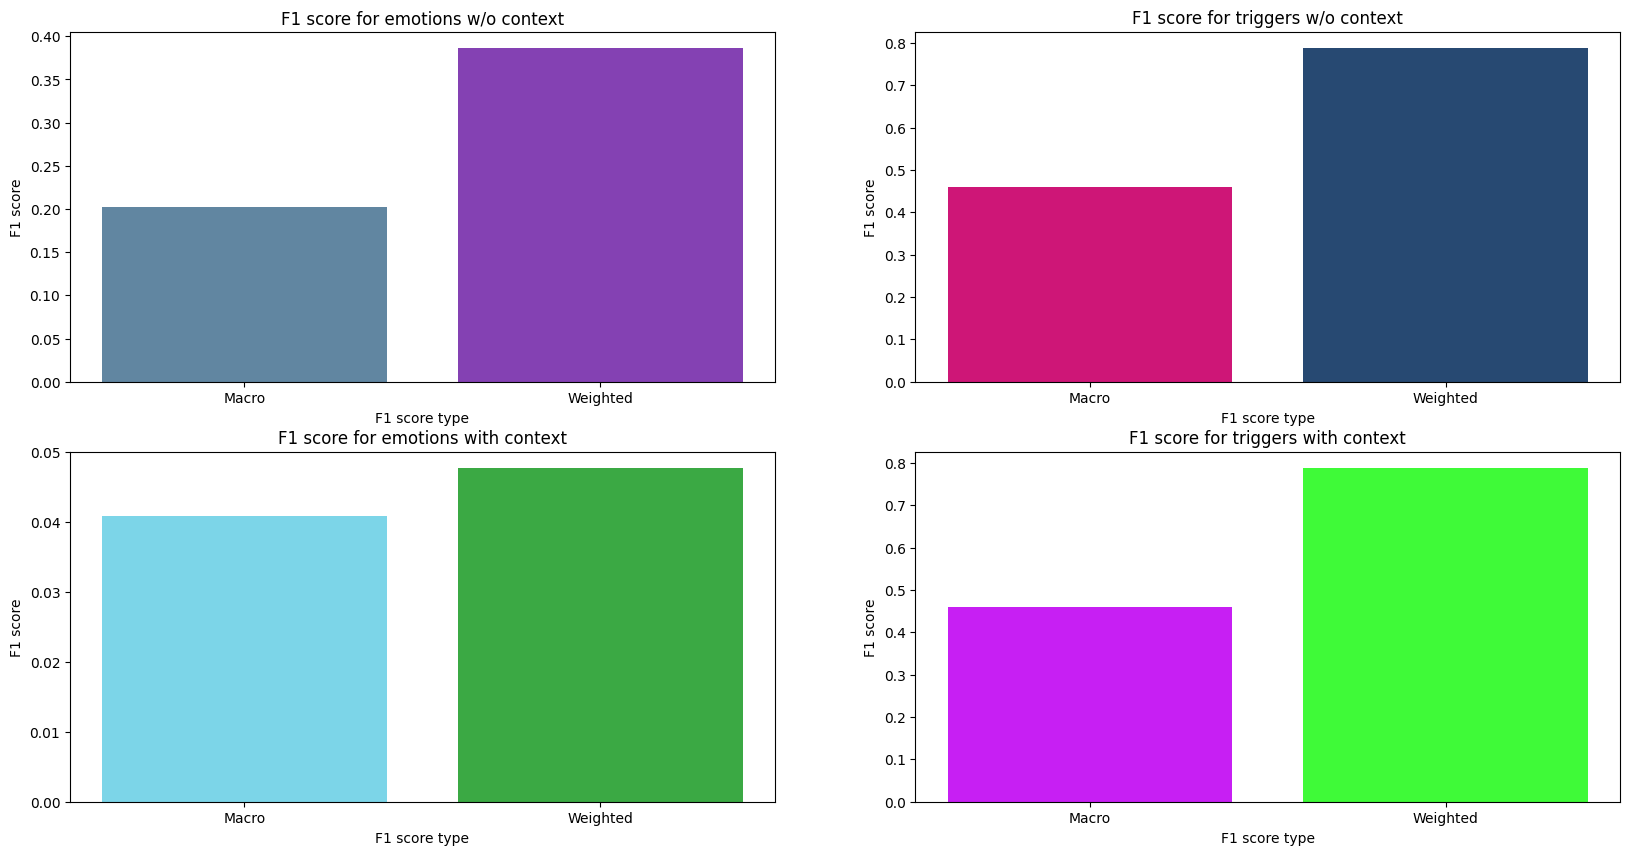

In [73]:
# plot macro f1 scores and weighted f1 scores for triggers and emotions as 4 bar plots
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.bar(["Macro", "Weighted"], [macro_f1_score_emotions, weighted_f1_score_emotions], color=set_color(2))
plt.title("F1 score for emotions w/o context")
plt.xlabel("F1 score type")
plt.ylabel("F1 score")
plt.subplot(2, 2, 2)
plt.bar(["Macro", "Weighted"], [macro_f1_score_triggers, weighted_f1_score_triggers], color=set_color(2))
plt.title("F1 score for triggers w/o context")
plt.xlabel("F1 score type")
plt.ylabel("F1 score")
plt.subplot(2, 2, 3)
plt.bar(["Macro", "Weighted"], [macro_f1_score_emotions_context, weighted_f1_score_emotions_context], color=set_color(2))
plt.title("F1 score for emotions with context")
plt.xlabel("F1 score type")
plt.ylabel("F1 score")
plt.subplot(2, 2, 4)
plt.bar(["Macro", "Weighted"], [macro_f1_score_triggers_context, weighted_f1_score_triggers_context], color=set_color(2))
plt.title("F1 score for triggers with context")
plt.xlabel("F1 score type")
plt.ylabel("F1 score")
plt.show()

As we can see from the plots the models get way better weighted average f1 scores. This is due to the fact that the models are able to classify even emotions that are hardly represented in the data, such as disgust, which is something that neither the baseline models nor previous trials without class weights were able to do. We purposely chose to add class weights to the loss function in order to see if the models could learn better from the data and thus improve the results as we noticed that the dataset was really imbalanced.

Altough this may lead to a worse performance on the majority classes, we believe that it is a good tradeoff as the models are able to learn from the data and thus classify even the minority classes.

Here we can see the confusion matrices for the models with and without context.

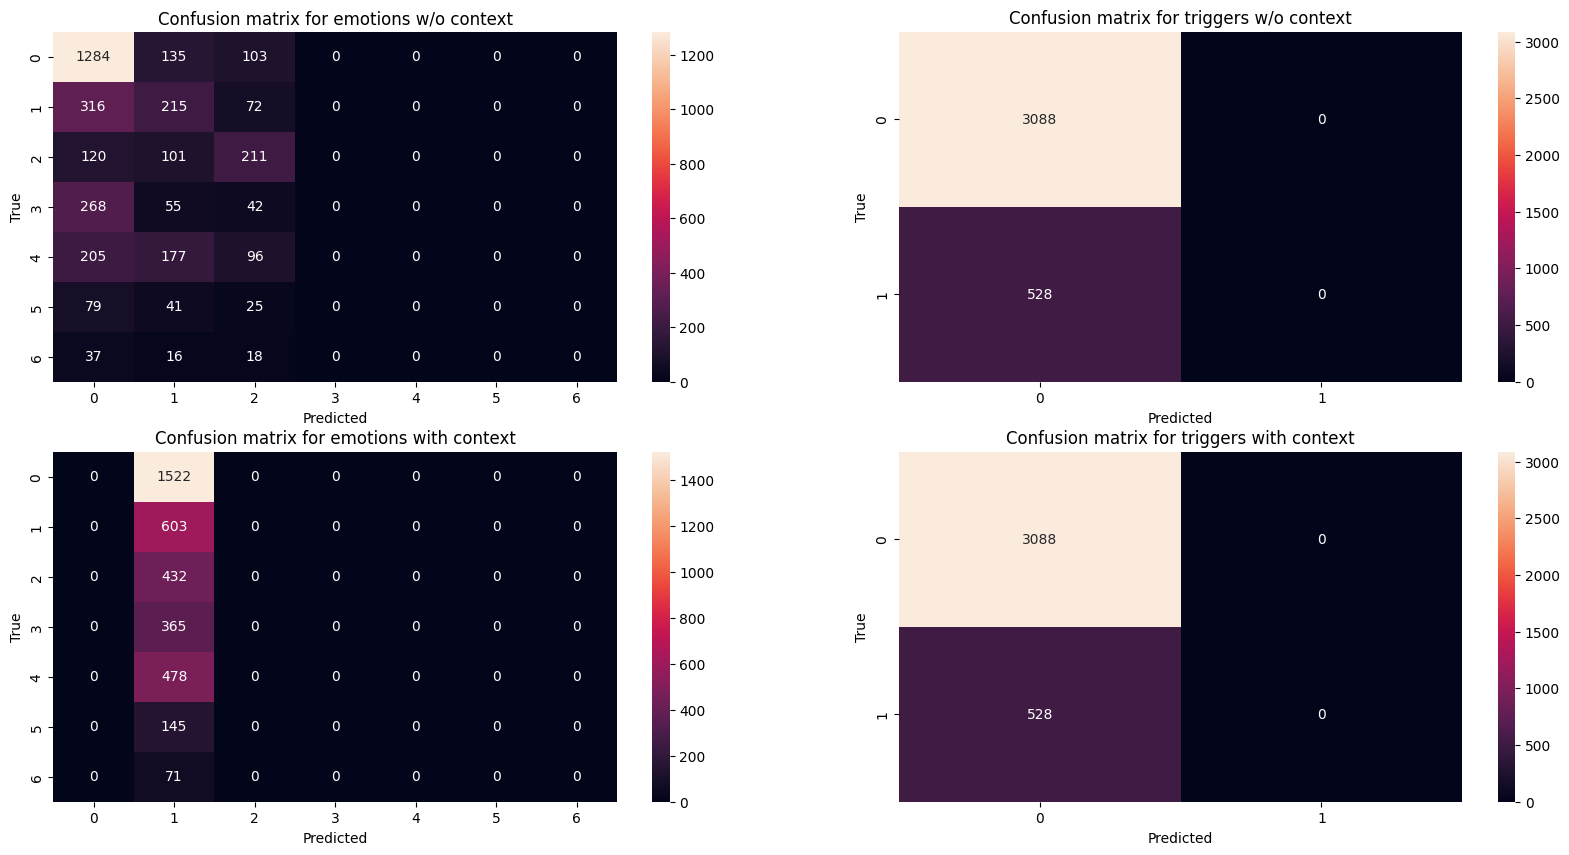

In [74]:
# get confusion matrices for triggers and emotions
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import seaborn as sns

cm_emotions = confusion_matrix(targets_emotion, outputs_emotion)
cm_triggers = confusion_matrix(targets_trigger, trigger_max_pred)

cm_emotions_context = confusion_matrix(targets_emotion_context, outputs_emotion_context)
cm_triggers_context = confusion_matrix(targets_trigger_context, outputs_trigger_context)

# plot confusion matrices for triggers and emotions
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title("Confusion matrix for emotions w/o context")
sns.heatmap(cm_emotions, annot=True, cmap=sns.color_palette("rocket", as_cmap=True), fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(2, 2, 2)
plt.title("Confusion matrix for triggers w/o context")
sns.heatmap(cm_triggers, annot=True, cmap=sns.color_palette("rocket", as_cmap=True), fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(2, 2, 3)
plt.title("Confusion matrix for emotions with context")
sns.heatmap(cm_emotions_context, annot=True, cmap=sns.color_palette("rocket", as_cmap=True), fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(2, 2, 4)
plt.title("Confusion matrix for triggers with context")
sns.heatmap(cm_triggers_context, annot=True, cmap=sns.color_palette("rocket", as_cmap=True), fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


As we can see in the confusion matrix for the w/o context, the model actually predict even the minority classes which is seen by looking at the high diagonal values and low remaining ammount of wrong predictions. Likewise we can see the same phenomenon in the confusion matrix for triggers.

We now compare some more results, including a real case prediction. 

The context model continues showing worse performances than the single-sentence-per-time one. This could be explained by the context being too complicated for the task at hand since emotions are almost entirely related to the single sentence at hand. On the other hand; triggers should be a little more context related but the dataset doesn't look consistent making it impossible for the model to find a labeling pattern that is nowhere to be found, or just very confused to the least.

In [75]:
# get a dialogue from test set
dialogue_index = 3699
def get_dialogue_no_context(dialogue_index):
    dialogue = []
    for index, row in bert_test.iterrows():
        if row["dialogue"] == dialogue_index:
            dialogue.append(row)
    text = []
    emotions = []
    triggers = []
    for elem in dialogue:
        text.append(elem["sentence"])
        emotions.append(elem["label"])
        triggers.append(elem["trigger"])
    return text, emotions, triggers
text, emotions, triggers = get_dialogue_no_context(dialogue_index)

In [76]:
# get prediction for this dialogue
def get_prediction(dialogue_index, model):
    text, emotions, triggers = get_dialogue_no_context(dialogue_index)
    predictions_emotions = []
    predictions_triggers = []
    for i in range(len(text)):
        inputs = tokenizer.encode_plus(
            text[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
        )

        ids = torch.tensor(inputs['input_ids'], dtype=torch.long).to(device)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).to(device)
        token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).to(device)
        output_emotion, output_trigger = model(ids.unsqueeze(0), mask.unsqueeze(0), token_type_ids.unsqueeze(0))
        predictions_emotions.extend(torch.argmax(output_emotion, axis=1).cpu().detach().numpy().tolist())
        predictions_triggers.extend(torch.sigmoid(output_trigger).cpu().detach().numpy().tolist())
    return predictions_emotions, predictions_triggers

Predictions for model without context:

In [77]:
predictions_emotions, predictions_triggers = get_prediction(dialogue_index, model)
# change predictions to match the format of the targets
predictions_triggers = trigger_max(predictions_triggers)
# change predicted emotions from integers to strings
predictions_emotions = [index_to_emotion[elem] for elem in predictions_emotions]
print(f"Text: {text}")
print(f"Emotions: {emotions}")
print(f"Triggers: {triggers}")
print(f"Predictions emotions: {predictions_emotions}")
print(f"Predictions triggers: {predictions_triggers}")

Text: ["Hey, so uh, y'know how there's something I wanted to talk to you about?", 'Oh yeah!', "Well, y'know how I'm trying to work things out with Emily.", "Well, there's this one thingÂ… Okay,  here goes.", 'I made a promise that--Oh hey!', 'What?', "You're nose is bleeding!", 'Oh God.', 'No!', 'Oh not again!', 'This-this happened when my grandfather died.', "It's ugh!", 'Sorry.']
Emotions: ['neutral', 'joy', 'joy', 'neutral', 'surprise', 'neutral', 'surprise', 'sadness', 'sadness', 'anger', 'sadness', 'disgust', 'sadness']
Triggers: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Predictions emotions: ['neutral', 'joy', 'neutral', 'neutral', 'joy', 'surprise', 'neutral', 'surprise', 'surprise', 'surprise', 'neutral', 'surprise', 'neutral']
Predictions triggers: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Predictions for model with context:

In [78]:
predictions_emotions_context, predictions_triggers_context = get_prediction(dialogue_index, model_context)
# change predictions to match the format of the targets
predictions_triggers_context = trigger_max(predictions_triggers_context)
# change predicted emotions from integers to strings
predictions_emotions_context = [index_to_emotion[elem] for elem in predictions_emotions_context]
print(f"Text: {text}")
print(f"Emotions: {emotions}")
print(f"Triggers: {triggers}")
print(f"Predictions emotions with context: {predictions_emotions_context}")
print(f"Predictions triggers with context: {predictions_triggers_context}")

Text: ["Hey, so uh, y'know how there's something I wanted to talk to you about?", 'Oh yeah!', "Well, y'know how I'm trying to work things out with Emily.", "Well, there's this one thingÂ… Okay,  here goes.", 'I made a promise that--Oh hey!', 'What?', "You're nose is bleeding!", 'Oh God.', 'No!', 'Oh not again!', 'This-this happened when my grandfather died.', "It's ugh!", 'Sorry.']
Emotions: ['neutral', 'joy', 'joy', 'neutral', 'surprise', 'neutral', 'surprise', 'sadness', 'sadness', 'anger', 'sadness', 'disgust', 'sadness']
Triggers: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Predictions emotions with context: ['joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy']
Predictions triggers with context: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


As we can see from both predictions the models are usually able to classify the majority of the emotions and triggers correctly. The context model struggles more, specially for minority classes. 

The trigger label is quite hard to predict as it doesn't seem to be related to the emotion expressed by the speaker. This is probably due to the fact that the trigger is not always expressed by the speaker, but it is also expressed by the listener. This is something that the models are not able to learn from the data as the trigger is always expressed by the speaker in the data.

From extended manual data analysis we also agreed on the triggers being set to 1 inconsistently, as we personally struggled to understand and predict the correct labeling.

What we need to check now is if the context is actually needed.

### Importance of context:

Another aspect we want to explore is the importance of context in the task. In order to do this we compare the results of the models with and without context.

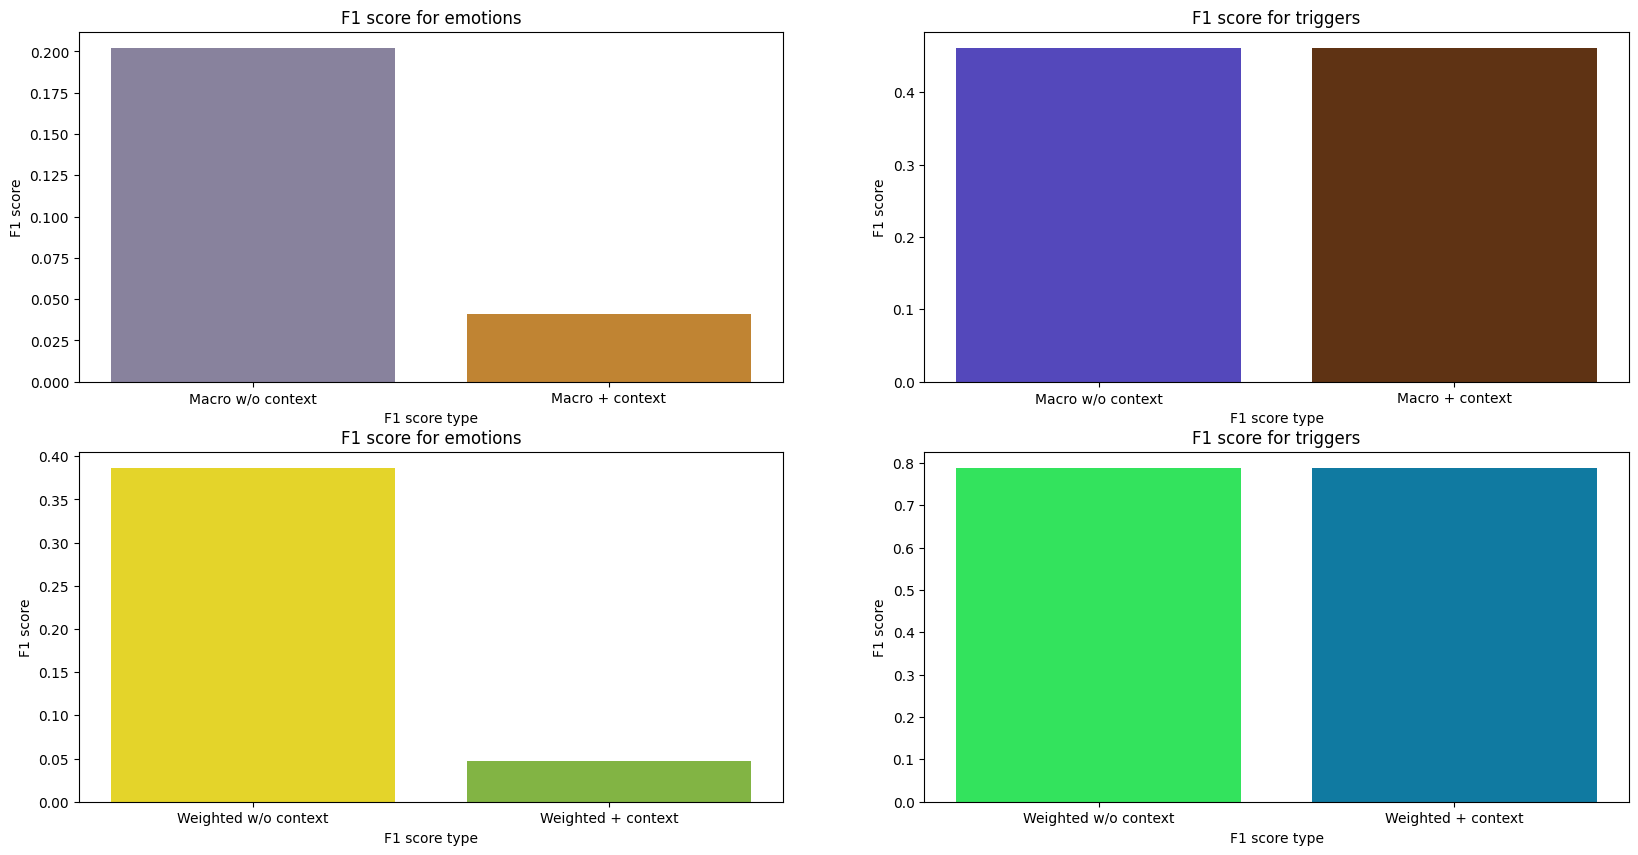

In [79]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.bar(["Macro w/o context", "Macro + context"], [macro_f1_score_emotions, macro_f1_score_emotions_context], color=set_color(2))
plt.title("F1 score for emotions")
plt.xlabel("F1 score type")
plt.ylabel("F1 score")
plt.subplot(2, 2, 2)
plt.bar(["Macro w/o context", "Macro + context"], [macro_f1_score_triggers, macro_f1_score_triggers_context], color=set_color(2))
plt.title("F1 score for triggers")
plt.xlabel("F1 score type")
plt.ylabel("F1 score")
plt.subplot(2, 2, 3)
plt.bar(["Weighted w/o context", "Weighted + context"], [weighted_f1_score_emotions, weighted_f1_score_emotions_context], color=set_color(2))
plt.title("F1 score for emotions")
plt.xlabel("F1 score type")
plt.ylabel("F1 score")
plt.subplot(2, 2, 4)
plt.bar(["Weighted w/o context", "Weighted + context"], [weighted_f1_score_triggers, weighted_f1_score_triggers_context], color=set_color(2))
plt.title("F1 score for triggers")
plt.xlabel("F1 score type")
plt.ylabel("F1 score")
plt.show()

Results still show that the model without context performs better than the one with context. This is probably due to the fact that the context is not always useful in the task, as the sentences are short and the meaning is usually clear from the sentence itself.

Let's the correlation between the emotions, triggers and the context.

We get each sentence with no duplicates:

In [80]:
def data_splitter_no_duplicates_sent(df):
    columns = ["sentence"]
     # split the utteracnes into sentences with their corresponding labels
    new_df = pd.DataFrame(columns=columns)
    for index, row in df.iterrows():
        for i in range(len(row["utterances"])):
            # We also split emotions and triggers while adding back the dialogue index which is the same for all the sentences in the same dialogue
            new_row = pd.DataFrame({"sentence": [row["utterances"][i]]})
            new_df = pd.concat([new_df, new_row], ignore_index=True).drop_duplicates()
    return new_df

And each pair of sentence-emotion and sentence-trigger with no duplicates:

In [81]:
def data_splitter_no_duplicates_emo(df):
    columns = ["label", "sentence"]
     # split the utteracnes into sentences with their corresponding labels
    new_df = pd.DataFrame(columns=columns)
    for index, row in df.iterrows():
        for i in range(len(row["emotions"])):
            # We also split emotions and triggers while adding back the dialogue index which is the same for all the sentences in the same dialogue
            new_row = pd.DataFrame({"label": [row["emotions"][i]], "sentence": [row["utterances"][i]]})
            new_df = pd.concat([new_df, new_row], ignore_index=True).drop_duplicates()
    return new_df

In [82]:
def data_splitter_no_duplicates_tri(df):
    columns = ["trigger", "sentence"]
     # split the utteracnes into sentences with their corresponding labels
    new_df = pd.DataFrame(columns=columns)
    for index, row in df.iterrows():
        for i in range(len(row["triggers"])):
            # We also split emotions and triggers while adding back the dialogue index which is the same for all the sentences in the same dialogue
            new_row = pd.DataFrame({"trigger": [row["triggers"][i]], "sentence": [row["utterances"][i]]})
            new_df = pd.concat([new_df, new_row], ignore_index=True).drop_duplicates()
    return new_df

We compute the correaltion between the emotions and the triggers and the context.

In [83]:
bert_train_sent = data_splitter_no_duplicates_sent(df_train.copy())
bert_train_emo = data_splitter_no_duplicates_emo(df_train.copy())
bert_train_tri = data_splitter_no_duplicates_tri(df_train.copy())

len_sent = len(bert_train_sent)
len_emo = len(bert_train_emo)
len_tri = len(bert_train_tri)

C:\Users\alepa\AppData\Local\Temp\ipykernel_5196\536741965.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True).drop_duplicates()


The correlation is computed as the length of the pair sentence-emotion and sentence-trigger minus the lenght of the sentence only set, divided by the length of the sentence only set.

In [84]:
print(f"Length of training set with only sentences: {len_sent}")
print(f"Length of training set with only emotions and sentences: {len_emo}")
print(f"Length of training set with only triggers and sentences: {len_tri}")

print(f"Percentage of emotions which were dependent on the context: {((len_emo - len_sent) / len_sent) * 100}%")
print(f"Percentage of triggers which were dependent on the context: {((len_tri - len_sent) / len_sent) * 100}%")

Length of training set with only sentences: 6296
Length of training set with only emotions and sentences: 6391
Length of training set with only triggers and sentences: 8847
Percentage of emotions which were dependent on the context: 1.5088945362134687%
Percentage of triggers which were dependent on the context: 40.517789072426936%


As we can see from the results the correlation between the emotions and the triggers and the context is really low. This is probably due to the fact that the context is not always useful in the task, as the sentences are short and the meaning is usually clear from the sentence itself. More specifically emotions have a really low correlation with the context, while triggers have a slightly higher correlation with the context. This is motivated by triggers supposedly measuring an emotion switch in the dialogue, inevitably related to more than just a single sentence.

This result is also in line with the fact that the model without context performs better than the one with context.

In [85]:
import gc

model = None
del model

with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

49591